# House price prediction

### The aim of this project is to predict the price of a house based on a dataset from USA.

In [6]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, max_error, explained_variance_score
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb


In [7]:
 
# Reading the dataset
data = pd.read_csv('data/house_usa.csv')

## EDA

In [8]:
data.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,sqft_above,sqft_basement,yr_built,yr_renovated,city
0,313000.0,3.0,1.50,1340,7912,1.5,0,3,1340,0,1955,2005,Shoreline
1,342000.0,3.0,2.00,1930,11947,1.0,0,4,1930,0,1966,0,Kent
2,420000.0,3.0,2.25,2000,8030,1.0,0,4,1000,1000,1963,0,Bellevue
3,550000.0,4.0,2.50,1940,10500,1.0,0,4,1140,800,1976,1992,Redmond
4,490000.0,2.0,1.00,880,6380,1.0,0,3,880,0,1938,1994,Seattle


In [9]:
data.shape

(4377, 13)

In [10]:
data.dtypes

price            float64
bedrooms         float64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
condition          int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
city              object
dtype: object

In [11]:
data.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,sqft_above,sqft_basement,yr_built,yr_renovated
count,4.377000e+03,4377.000000,4377.000000,4377.00000,4.377000e+03,4377.000000,4377.000000,4377.000000,4377.000000,4377.000000,4377.000000,4377.000000
mean,4.846856e+05,3.360292,2.104352,2043.81517,1.461526e+04,1.496459,0.004569,3.447110,1756.235778,287.579392,1970.865661,810.642678
std,2.243187e+05,0.886216,0.726282,825.97383,3.599514e+04,0.536530,0.067450,0.672319,776.224021,426.548380,29.499012,979.834085
min,0.000000e+00,0.000000,0.000000,370.00000,6.380000e+02,1.000000,0.000000,1.000000,370.000000,0.000000,1900.000000,0.000000
25%,3.150000e+05,3.000000,1.750000,1440.00000,5.000000e+03,1.000000,0.000000,3.000000,1170.000000,0.000000,1951.000000,0.000000
50%,4.499500e+05,3.000000,2.250000,1930.00000,7.573000e+03,1.500000,0.000000,3.000000,1540.000000,0.000000,1975.000000,0.000000
75%,6.150000e+05,4.000000,2.500000,2520.00000,1.073100e+04,2.000000,0.000000,4.000000,2210.000000,580.000000,1996.000000,1999.000000
max,1.198000e+06,9.000000,6.250000,8020.00000,1.074218e+06,3.500000,1.000000,5.000000,8020.000000,2300.000000,2014.000000,2014.000000


In [12]:
data.isna().sum()

price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
condition        0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
city             0
dtype: int64

In [13]:
data_numeric=data.drop('city', axis='columns')

<AxesSubplot:>

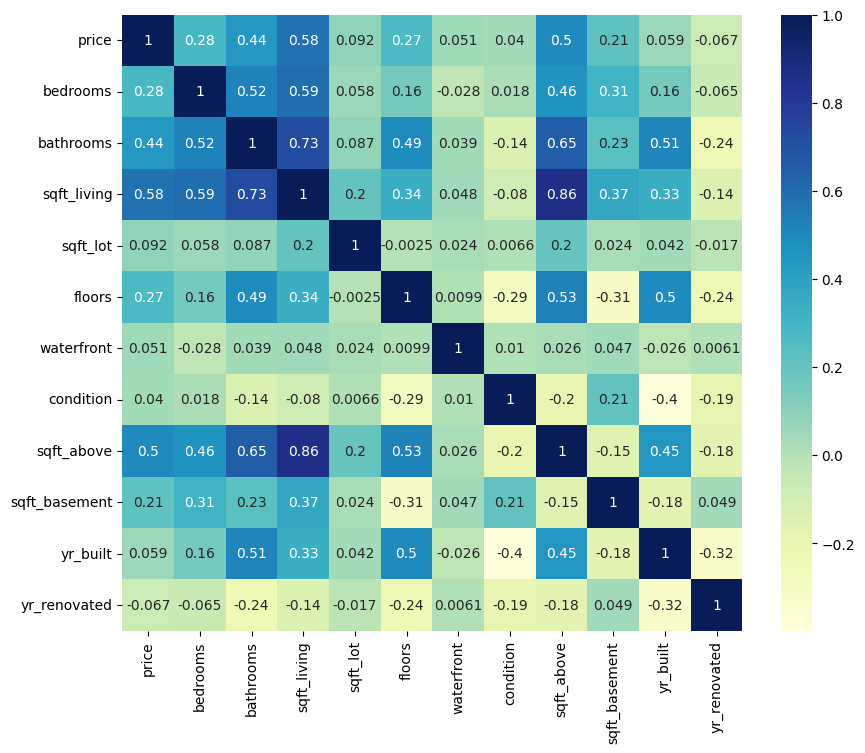

In [14]:
plt.figure(figsize=(10, 8))
sns.heatmap(data_numeric.corr(), cmap="YlGnBu", annot=True)

It seems that Waterfront and condition have no correlation with price so I would not included in this analysis.
Also, sqft_above and swft_living have a high correlation so I would keep only the latter.

In [15]:
data_numeric.drop(['waterfront', 'condition', 'sqft_above'], axis='columns', inplace=True)

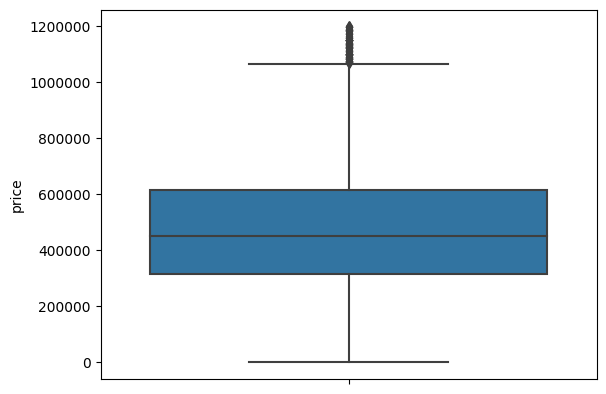

In [16]:
sns.boxplot(data=data_numeric, y='price')
plt.ticklabel_format(style='plain', axis='y')

In [17]:
data_numeric.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'sqft_basement', 'yr_built', 'yr_renovated'],
      dtype='object')

In [18]:
data_numeric['yr_renovated'].mask(data_numeric['yr_renovated'] == 0, data_numeric['yr_built'], inplace=True)
data_numeric


,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_basement,yr_built,yr_renovated
0,313000.000000,3.0,1.50,1340,7912,1.5,0,1955,2005
1,342000.000000,3.0,2.00,1930,11947,1.0,0,1966,1966
2,420000.000000,3.0,2.25,2000,8030,1.0,1000,1963,1963
3,550000.000000,4.0,2.50,1940,10500,1.0,800,1976,1992
4,490000.000000,2.0,1.00,880,6380,1.0,0,1938,1994
...,...,...,...,...,...,...,...,...,...
4372,308166.666667,3.0,1.75,1510,6360,1.0,0,1954,1979
4373,534333.333333,3.0,2.50,1460,7573,2.0,0,1983,2009
4374,416904.166667,3.0,2.50,3010,7014,2.0,0,2009,2009
4375,203400.000000,4.0,2.00,2090,6630,1.0,1020,1974,1974


In [19]:
data_numeric['total_m2'] = data_numeric['sqft_living']/10.764
data_numeric['lot_m2'] = data_numeric['sqft_lot']/10.764
data_numeric['basement_m2'] = data_numeric['sqft_basement']/10.764
data_numeric = data_numeric.astype({'bathrooms':int, 'total_m2':int, 'lot_m2':int, 'basement_m2':int, 'bedrooms': int})
data_numeric['age'] = 2023 - data_numeric['yr_built']
data_numeric['age_renovated'] = 2023 - data_numeric['yr_renovated']

In [20]:
data_numeric.drop(['sqft_living', 'sqft_lot', 'sqft_basement', 'yr_built', 'yr_renovated'], axis='columns', inplace=True)
data_numeric.head()

,price,bedrooms,bathrooms,floors,total_m2,lot_m2,basement_m2,age,age_renovated
0,313000.0,3,1,1.5,124,735,0,68,18
1,342000.0,3,2,1.0,179,1109,0,57,57
2,420000.0,3,2,1.0,185,746,92,60,60
3,550000.0,4,2,1.0,180,975,74,47,31
4,490000.0,2,1,1.0,81,592,0,85,29


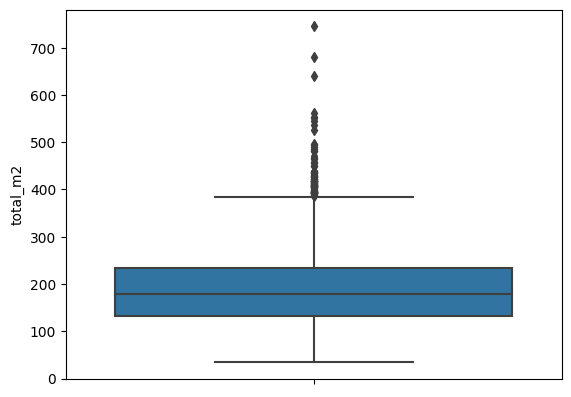

In [21]:
sns.boxplot(data=data_numeric, y='total_m2')
plt.ticklabel_format(style='plain', axis='y')

There are some outliers in m2 column so I'll remove them.

In [22]:
Q1 = np.percentile(data_numeric['total_m2'], 25,
                   interpolation = 'midpoint')
 
Q3 = np.percentile(data_numeric['total_m2'], 75,
                   interpolation = 'midpoint')
IQR = Q3 - Q1
  
# Upper bound
upper=Q3+1.5*IQR
# Lower bound
lower=Q1-1.5*IQR
# Removing the outliers
data_numeric = data_numeric[(data_numeric.total_m2<upper) & (data_numeric.total_m2>lower)]
data_numeric.shape

/tmp/ipykernel_106173/841108852.py:1: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they. (Deprecated NumPy 1.22)
  Q1 = np.percentile(data_numeric['total_m2'], 25,
/tmp/ipykernel_106173/841108852.py:4: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they. (Deprecated NumPy 1.22)
  Q3 = np.percentile(data_numeric['total_m2'], 75,


(4301, 9)

## LGBoost

In [23]:
# Seperating the target and features
# target ->y, features -> X
y = data_numeric['price']
X = data_numeric.drop('price', axis='columns')

In [24]:
# Splitting into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [25]:
param_grid = {
    'learning_rate': [0.1, 0.01],
    'n_estimators': [50, 100, 150],
    'max_depth': [4, 6],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'subsample': [0.7, 0.8, 0.9],
    'min_child_samples': [1, 5, 10]
}

In [26]:
estimator = lgb.LGBMRegressor(objective='regression', 
                            random_state=101)

In [27]:
model = GridSearchCV(estimator=estimator, 
                    param_grid=param_grid,
                    cv=3, 
                    n_jobs=-1, 
                    scoring='neg_root_mean_squared_error')
model.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=LGBMRegressor(objective='regression', random_state=101),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.7, 0.8, 0.9],
                         'learning_rate': [0.1, 0.01], 'max_depth': [4, 6],
                         'min_child_samples': [1, 5, 10],
                         'n_estimators': [50, 100, 150],
                         'subsample': [0.7, 0.8, 0.9]},
             scoring='neg_root_mean_squared_error')

In [28]:
best_params = model.best_estimator_
print(best_params)

LGBMRegressor(colsample_bytree=0.9, max_depth=4, min_child_samples=5,
              n_estimators=50, objective='regression', random_state=101,
              subsample=0.7)


In [29]:
best_model = lgb.LGBMRegressor(colsample_bytree=0.9, 
                               max_depth=4, 
                               min_child_samples=5,
                               n_estimators=50, 
                               objective='regression', 
                               random_state=101,
                               subsample=0.7)

In [30]:
best_model.fit(X_train, y_train)

LGBMRegressor(colsample_bytree=0.9, max_depth=4, min_child_samples=5,
              n_estimators=50, objective='regression', random_state=101,
              subsample=0.7)

In [31]:
features = X_train.columns
importance_values = best_model.feature_importances_

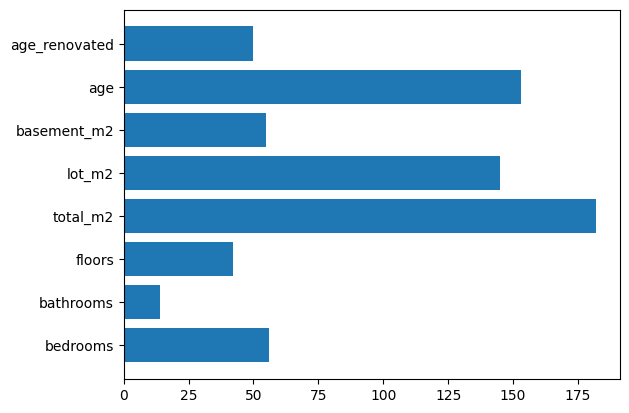

In [32]:
plt.barh(y=range(len(features)),
        width=importance_values,
        tick_label=features)
plt.show()

### We can observe that total_m2, lot_m2 and age have greater importance than the rest of the variables.

In [33]:
y_pred = best_model.predict(X_test)
print('RMSE:',mean_squared_error(y_test, y_pred, squared=False))
print('MAE:',mean_absolute_error(y_test, y_pred))
print('Max Error:',max_error(y_test, y_pred))
print('Explained Variance Score:',explained_variance_score(y_test, y_pred))

RMSE: 165274.44632778855
MAE: 125419.06770688744
Max Error: 915006.7363864136
Explained Variance Score: 0.40545300424939257


## Train a new model with only the important features

In [34]:
new_data = data_numeric.drop(['floors', 'bathrooms'], axis='columns')
new_data.describe()

,price,bedrooms,total_m2,lot_m2,basement_m2,age,age_renovated
count,4.301000e+03,4301.000000,4301.000000,4301.000000,4301.000000,4301.000000,4301.000000
mean,4.794706e+05,3.342944,184.897931,1295.785631,25.645664,52.493839,38.026273
std,2.185138e+05,0.878047,69.004975,3234.546915,38.022509,29.527768,26.803185
min,0.000000e+00,0.000000,34.000000,59.000000,0.000000,9.000000,9.000000
25%,3.149500e+05,3.000000,132.000000,464.000000,0.000000,27.000000,18.000000
50%,4.450000e+05,3.000000,177.000000,697.000000,0.000000,48.000000,29.000000
75%,6.060000e+05,4.000000,231.000000,973.000000,51.000000,72.000000,50.000000
max,1.198000e+06,9.000000,385.000000,99797.000000,192.000000,123.000000,123.000000


In [35]:
# Seperating the target and features
# target ->y, features -> X
y = new_data['price']
X = new_data.drop('price', axis='columns')

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [37]:
new_model = GridSearchCV(estimator=estimator, 
                    param_grid=param_grid,
                    cv=3, 
                    n_jobs=-1, 
                    scoring='neg_root_mean_squared_error')
new_model.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=LGBMRegressor(objective='regression', random_state=101),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.7, 0.8, 0.9],
                         'learning_rate': [0.1, 0.01], 'max_depth': [4, 6],
                         'min_child_samples': [1, 5, 10],
                         'n_estimators': [50, 100, 150],
                         'subsample': [0.7, 0.8, 0.9]},
             scoring='neg_root_mean_squared_error')

In [38]:
best_params = new_model.best_estimator_
print(best_params)

LGBMRegressor(colsample_bytree=0.8, max_depth=4, min_child_samples=5,
              n_estimators=50, objective='regression', random_state=101,
              subsample=0.7)


In [39]:
best_model2 = lgb.LGBMRegressor(colsample_bytree=0.8, 
                               max_depth=4, 
                               min_child_samples=5,
                               n_estimators=50, 
                               objective='regression', 
                               random_state=101,
                               subsample=0.7)
best_model2.fit(X_train, y_train)

LGBMRegressor(colsample_bytree=0.8, max_depth=4, min_child_samples=5,
              n_estimators=50, objective='regression', random_state=101,
              subsample=0.7)

In [43]:
y_pred2 = best_model2.predict(X_test)
print('RMSE:',mean_squared_error(y_test, y_pred2, squared=False))
print('MAE:',mean_absolute_error(y_test, y_pred2))
print('Max Error:',max_error(y_test, y_pred2))
print('Explained Variance Score:',explained_variance_score(y_test, y_pred2))

RMSE: 164426.0380419707
MAE: 125727.57552841393
Max Error: 951780.8035350358
Explained Variance Score: 0.4118166087923558


#### As we can observe, the explained variance didn't increase significantly (from 0.40 to 0.41) but the new model has fewer variables so it's a simpler one.

## Save the model to use it for a web app

In [44]:
# Saving the model
import joblib
 
joblib.dump(best_model2, "lgb_model.sav")

['lgb_model.sav']

In [46]:
X_train

,bedrooms,total_m2,lot_m2,basement_m2,age,age_renovated
1839,3,248,905,99,44,44
4140,3,183,1030,73,56,56
2136,3,165,629,51,33,14
3701,4,231,884,0,55,55
889,5,195,905,83,16,16
...,...,...,...,...,...,...
2940,3,117,752,36,73,18
2806,4,126,557,0,106,14
918,3,145,722,0,41,41
4044,2,72,363,0,105,105
